In [1]:
import cv2
import glob
import imageio
import keras 
import numpy as np
import os
import scipy.io
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imshow
from PIL import Image

%matplotlib inline

Using TensorFlow backend.


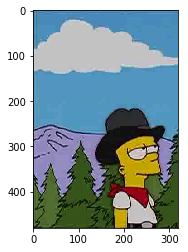

In [2]:
# Plot single image
def plotBart(image_location):
    content_image = imageio.imread(image_location)
    imshow(content_image)
    return

image_location = "./the-simpsons-characters-dataset/simpsons_dataset/bart_simpson/pic_0000.jpg"
plotBart(image_location)

In [3]:
# Global varialbes
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

NUM_CLASSES = 10
NUM_EPOCHS = 100

# Hyperparameters
BATCH_SIZE = 32
FC_LAYERS = [1024, 1024, 1024] # Fully connected layers
DROPOUT = 0.1 # Dropout rate = 1- keep_prob
LR = 0.0001

In [4]:
def load_train_data():
    train_dir = './simpsons_dataset/train' # To change

    train_datagen =  ImageDataGenerator(
          preprocessing_function=preprocess_input,
          rescale=1./255,
          rotation_range=0, # To change
          horizontal_flip=True, 
          vertical_flip=True) 

    train_generator = train_datagen.flow_from_directory(train_dir, 
                                                        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                        batch_size=BATCH_SIZE, 
                                                        shuffle = True)
    return train_generator

In [5]:
def load_dev_data():
    dev_dir = './simpsons_dataset/dev' # To change

    dev_datagen = ImageDataGenerator(rescale=1./255)
    dev_generator = dev_datagen.flow_from_directory(dev_dir, 
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                    batch_size=BATCH_SIZE, 
                                                    shuffle = True)
    
    return dev_generator

In [6]:
def load_test_data():
    test_dir = './simpsons_dataset/test' # To change

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(test_dir, 
                                                      target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                      batch_size=BATCH_SIZE, 
                                                      shuffle = True)
    
    return test_generator

In [7]:
# Load data
train_generator = load_train_data()
dev_generator = load_dev_data()
test_generator = load_test_data()

Found 100 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [8]:
def build_model(base_model): 
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    
    for fc in FC_LAYERS:
        # New FC layer
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(rate=DROPOUT)(x)

    # New softmax layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x) 
    
    model_built = Model(inputs=base_model.input, outputs=predictions)

    return model_built

In [9]:
def build_model_using_VGG19():
    # Change this to use different trained models
    base_model = VGG19(weights='imagenet', 
                       include_top=False, # Won’t be keeping the Fully-Connected (FC) layers at the end of the mode
                       input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

    model = build_model(base_model)
    model.summary()
    return model

In [10]:
model = build_model_using_VGG19()

# Compile model
opt = Adam(lr=LR)
#opt = SGD(lr=LR)
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)

In [11]:
# Plot the training and validation loss & accuracy
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'rs')
    plt.plot(epochs, val_acc, 'g^')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'rs')
    plt.plot(epochs, val_loss, 'g^')
    plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')

In [12]:
def run_model():
    # Checkpoints
    checkpoint_filepath = "./checkpoints/" + "model_weights.h5"
    checkpoint = ModelCheckpoint(checkpoint_filepath, verbose=1, mode='auto')
    callbacks_list = [checkpoint]

    # Train model using train and dev data
    history = model.fit_generator(train_generator, 
                                  steps_per_epoch=train_generator.n // train_generator.batch_size, 
                                  validation_data=dev_generator, 
                                  validation_steps=dev_generator.n // dev_generator.batch_size, 
                                  epochs=NUM_EPOCHS, 
                                  workers=20, 
                                  shuffle=True, 
                                  callbacks=callbacks_list)

    # Plot training and dev: loss and accuracy
    plot_training(history)
    
    # Test model using test data
    test = model.evaluate_generator(test_generator,
                                    steps = test_generator.n // test_generator.batch_size,
                                    workers=20)
    print('Test Loss: ' + str(test[0]))
    print('Test Accuracy ' + str(test[1]))

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3/3 [==============================] - 13s 4s/step - loss: 2.4332 - acc: 0.0938 - val_loss: 2.3012 - val_acc: 0.1458

Epoch 00001: saving model to ./checkpoints/model_weights.h5
Epoch 2/100
3/3 [==============================] - 9s 3s/step - loss: 2.3618 - acc: 0.0345 - val_loss: 2.2461 - val_acc: 0.2206

Epoch 00002: saving model to ./checkpoints/model_weights.h5
Epoch 3/100
3/3 [==============================] - 9s 3s/step - loss: 2.3168 - acc: 0.1696 - val_loss: 2.2481 - val_acc: 0.2353

Epoch 00003: saving model to ./checkpoints/model_weights.h5
Epoch 4/100
3/3 [==============================] - 8s 3s/step - loss: 2.2834 - acc: 0.1838 - val_loss: 2.2426 - val_acc: 0.1324

Epoch 00004: saving model to ./checkpoints/model_weights.h5
Epoch 5/100
3/3 [==============================] - 11s 4s/step - loss: 2.1424 - acc: 0.2812 - val_loss: 2.1895 - val_acc: 0.2083

Epoch 00005: saving model to ./checkpoints/model_weights.h5
Epoch

Epoch 43/100
3/3 [==============================] - 8s 3s/step - loss: 0.6414 - acc: 0.8851 - val_loss: 1.1367 - val_acc: 0.5588

Epoch 00043: saving model to ./checkpoints/model_weights.h5
Epoch 44/100
3/3 [==============================] - 8s 3s/step - loss: 0.8477 - acc: 0.8277 - val_loss: 1.1581 - val_acc: 0.5882

Epoch 00044: saving model to ./checkpoints/model_weights.h5
Epoch 45/100
3/3 [==============================] - 11s 4s/step - loss: 0.7708 - acc: 0.8750 - val_loss: 1.0659 - val_acc: 0.6458

Epoch 00045: saving model to ./checkpoints/model_weights.h5
Epoch 46/100
3/3 [==============================] - 8s 3s/step - loss: 0.6919 - acc: 0.8621 - val_loss: 1.0222 - val_acc: 0.6912

Epoch 00046: saving model to ./checkpoints/model_weights.h5
Epoch 47/100
3/3 [==============================] - 8s 3s/step - loss: 0.7138 - acc: 0.8304 - val_loss: 0.9773 - val_acc: 0.6471

Epoch 00047: saving model to ./checkpoints/model_weights.h5
Epoch 48/100
3/3 [==============================]

3/3 [==============================] - 8s 3s/step - loss: 0.1349 - acc: 0.9885 - val_loss: 0.9340 - val_acc: 0.6471

Epoch 00086: saving model to ./checkpoints/model_weights.h5
Epoch 87/100
3/3 [==============================] - 8s 3s/step - loss: 0.1394 - acc: 0.9655 - val_loss: 0.6794 - val_acc: 0.8235

Epoch 00087: saving model to ./checkpoints/model_weights.h5
Epoch 88/100
3/3 [==============================] - 8s 3s/step - loss: 0.0958 - acc: 1.0000 - val_loss: 0.4871 - val_acc: 0.8676

Epoch 00088: saving model to ./checkpoints/model_weights.h5
Epoch 89/100
3/3 [==============================] - 11s 4s/step - loss: 0.1366 - acc: 1.0000 - val_loss: 0.5634 - val_acc: 0.8125

Epoch 00089: saving model to ./checkpoints/model_weights.h5
Epoch 90/100
3/3 [==============================] - 8s 3s/step - loss: 0.0894 - acc: 1.0000 - val_loss: 0.6413 - val_acc: 0.7941

Epoch 00090: saving model to ./checkpoints/model_weights.h5
Epoch 91/100
3/3 [==============================] - 8s 3s/step

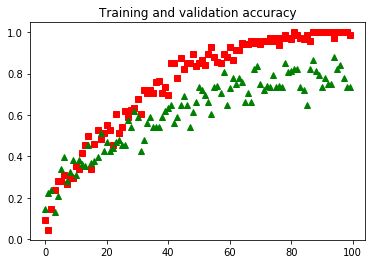

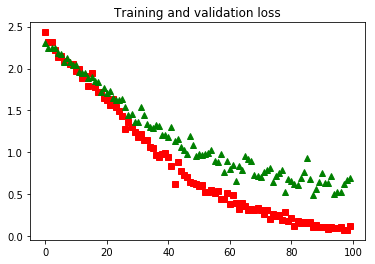

Test Loss: 0.6783504287401835
Test Accuracy 0.7604166666666666


<Figure size 432x288 with 0 Axes>

In [13]:
run_model()